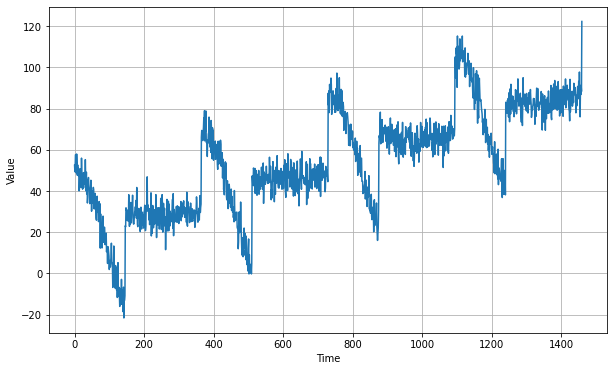

In [1]:
import numpy as np
import matplotlib.pylab as plt
from tensorflow import keras


def plot_series(time, series, format='-', start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period / period)
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
basline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(
    time, period=365, amplitude=amplitude)
# Updata with noise
series += noise(time, noise_level, seed=42)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [2]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [3]:
import tensorflow as tf


def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

Test the best leraning rate

D:\Python\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Text(0.5, 0, 'Learning rate')

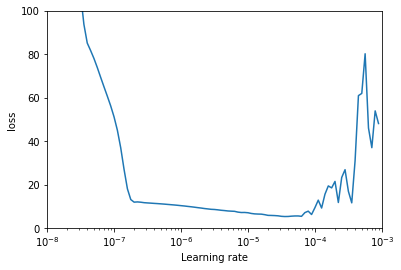

In [4]:
window_size = 20
batch_size = 128
shuffle_buffer_size = 1000

train_set = windowed_dataset(
    x_train, window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer_size)

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    (lambda epoch: 1e-8 * 10**(epoch / 20)))

model.compile(loss=tf.keras.losses.Huber(), #Huber is not be sensitive to the separete data, which can reduce the impact of noise. 
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, verbose=0, callbacks=[lr_schedule])

lrs = 1e-8 * (10**(np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 100])
plt.ylabel('loss')
plt.xlabel('Learning rate')


The best learning rate is between 10^-5 and 10^-4

D:\Python\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


6.2499824


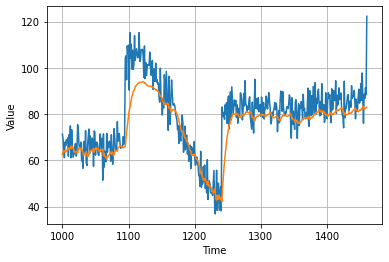

In [5]:
window_size = 20
batch_size = 128
shuffle_buffer_size = 1000
tf.keras.backend.clear_session()

dataset = windowed_dataset(x_train,
                           window_size,
                           batch_size=batch_size,
                           shuffle_buffer=shuffle_buffer_size)

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                           input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10 ** (epoch / 20))

optimizer = tf.keras.optimizers.SGD(lr=2e-5, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(
    ),  #Huber is not be sensitive to the separete data, which can reduce the impact of noise. 
    optimizer=optimizer,
    metrics=["mae"])

history = model.fit(dataset, epochs=100, verbose=0)
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
result = np.array(forecast)[:, 0, 0]
plot_series(time_valid, x_valid)
plot_series(time_valid, result)

print(tf.keras.metrics.mean_absolute_error(x_valid, result).numpy())